# Deep Learning Mini Project, Spring 2023

Authors: Nico Colosso, Richard Fu, Lenox Hsu

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

import time
import random

## The Residual Building Block

- 2 Weight Layers
  - Layer 1: $Conv → BatchNorm → ReLU$
  - Layer 2: $Conv → BatchNorm → SkippedConnection → ReLU$

We need to include a stride parameter in Weight Layer 1, as Residual Layers 2, 3, and 4 all have strides of 2 in the first Weight Layer of the first Building Block.

We also need to include padding on both Convolutional layers to address the mismatch in dimensions caused by applying the convolutions, as we discussed in recitation.

In [2]:
class BuildingBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, downsample=None):
    super(BuildingBlock, self).__init__()
    self.downsample = downsample

    # Layer 1
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True)
    
    # Layer 2
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True)

  def forward(self, x):
    identity = x

    # Layer 1
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)

    # Layer 2
    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu2(out)

    return out

We will test our BuildingBlock module on a randomly populated tensor. We will simulate the first block of Residual Layer 2, which accepts an input image of size 32x32 with 64 channels and outputs a 16x16 image with 128 channels, to see if we get the expected output dimensions.

In [3]:
IN_CHANNELS = 64
OUT_CHANNELS = 128
CONV_KERNEL_SIZE = 3
SKIP_KERNEL_SIZE = 1

x = torch.randn(1, IN_CHANNELS, 32, 32)
print(f"x shape (expected: 1 x 64 x 32 x 32)\n{x.shape}\n")


# We need to define the downsample module
DOWNSAMPLE = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, kernel_size=SKIP_KERNEL_SIZE, stride=2, bias=False),
    nn.BatchNorm2d(OUT_CHANNELS)
)

block = BuildingBlock(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, kernel_size=CONV_KERNEL_SIZE, stride=2, downsample=DOWNSAMPLE)
y = block(x)
print(f"y shape (expected: 1 x 128 x 16 x 16)\n{y.shape}")

x shape (expected: 1 x 64 x 32 x 32)
torch.Size([1, 64, 32, 32])

y shape (expected: 1 x 128 x 16 x 16)
torch.Size([1, 128, 16, 16])


## The ResNet18 Model

Hyperparameters:
- $C_i$ - number of channels in the $i$th layer
- $F_i$ - filter size in the $i$th layer
- $K_i$ - kernel size in the $i$th skip connection
- $P$ - pool size in the average pool layer


Forward-Pass Artichecture (note: the dimensions below are in the format *NumChannels x W x H*)

1. First Weight Layer
  - $Conv → BatchNorm → ReLU$
  - Takes a *3 x 32 x 32* image as input
  - Outputs a *$C_0$ x 32 x 32* image
2. 4 Residual Layers (each composed of 2 Building Blocks)
  - (1) Each Weight Layer outputs a *$C_1$ x 32 x 32* image
  - (2) Each Weight Layer outputs a *$C_2$ x 16 x 16* image
  - (3) Each Weight Layer ouptuts a *$C_3$ x 8 x 8* image
  - (4) Each Weight Layer outputs a *$C_4$ x 4 x 4* image
3. Avg Pooling Layer
4. Fully Connected Layer




In [4]:
class ResNet18(nn.Module):
  def __init__(self, img_channels, num_classes, num_channels, conv_kernel_size, skip_kernel_size, pool_size):
    super(ResNet18, self).__init__()

    # First Weight Layer
    self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=NUM_CHANNELS[0], kernel_size=conv_kernel_size[0], padding=1)
    self.bn1 = nn.BatchNorm2d(NUM_CHANNELS[0])
    self.relu = nn.ReLU(inplace=True)

    # Residual Layers
    self.layer1 = self._make_layer(in_channels=num_channels[0], out_channels=num_channels[1],
                                   conv_kernel_size=conv_kernel_size[1], skip_kernel_size=skip_kernel_size[1])
   
    self.layer2 = self._make_layer(in_channels=num_channels[1], out_channels=num_channels[2],
                                   conv_kernel_size=conv_kernel_size[2], skip_kernel_size=skip_kernel_size[2], stride=2)
   
    self.layer3 = self._make_layer(in_channels=num_channels[2], out_channels=num_channels[3],
                                   conv_kernel_size=conv_kernel_size[3], skip_kernel_size=skip_kernel_size[3], stride=2)
   
    self.layer4 = self._make_layer(in_channels=num_channels[3], out_channels=num_channels[4],
                                   conv_kernel_size=conv_kernel_size[4], skip_kernel_size=skip_kernel_size[4], stride=2)

    # Remaining Layers
    self.avgpool = nn.AvgPool2d(pool_size)


    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(num_channels[4], num_classes))


    self.fc = nn.Linear(num_channels[4], num_classes)


  def _make_layer(self, in_channels, out_channels, conv_kernel_size, skip_kernel_size, stride=1):
    downsample = None
    if stride > 1:
      downsample = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=skip_kernel_size, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )

    block1 = BuildingBlock(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=conv_kernel_size, stride=stride, downsample=downsample)
    
    block2 = BuildingBlock(in_channels=out_channels, out_channels=out_channels,
                           stride=1, kernel_size=conv_kernel_size, downsample=None)
    
    return nn.Sequential(block1, block2)

  def forward(self, x):

    # First Weight Layer
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    # Residual Layers
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)

    # Remaining Layers
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.classifier(out)

    return out

We will initialize our model and print out the summary with the number of trainable parameters.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_CHANNELS = 3
NUM_CLASSES = 10
NUM_CHANNELS = [64, 64, 128, 324, 144]
CONV_KERNEL_SIZE = [3, 3, 3, 3, 3]
SKIP_KERNEL_SIZE = [0, 1, 1, 1, 1] # 0 index is not used for anything
POOL_SIZE = 4

model = ResNet18(img_channels=IMG_CHANNELS, num_classes=NUM_CLASSES,
                 num_channels=NUM_CHANNELS, conv_kernel_size=CONV_KERNEL_SIZE,
                 skip_kernel_size=SKIP_KERNEL_SIZE, pool_size=POOL_SIZE)

model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): 

In [6]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    BuildingBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [7]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        #nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        #nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): 

## Prepping the CIFAR-10 Dataset

Now that we have defined our model, we will set up the data loaders and normalization for CIFAR-10 by following the tutorial in the Pytorch documentation and reusing parts of Homework 2 Question 4.

In [8]:
train_data = datasets.CIFAR10(root='./data', train=True,
                              download=True)


means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

train_tfm = transforms.Compose(
    [transforms.RandomCrop(32, padding=2, padding_mode='reflect'), 
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean = means, std = stds)])

test_tfm = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean = means, std = stds)])

#regular transform, apply data augmentation later
train_data = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform = train_tfm)

test_data = datasets.CIFAR10(root='./data', train=False,
                             download=True, transform=test_tfm)




classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 80653558.09it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Split the training data into training and validation sets
import copy

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_tfm

In [10]:
# Create the Data Loaders

BATCH_SIZE = 64

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2)

valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE,
                               shuffle=False, num_workers=2)

test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2)

In [11]:
# Helper function to show images, code copied from online source

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

We will test the helper function `imshow` on an image from the training set

torch.Size([3, 32, 32]) 7


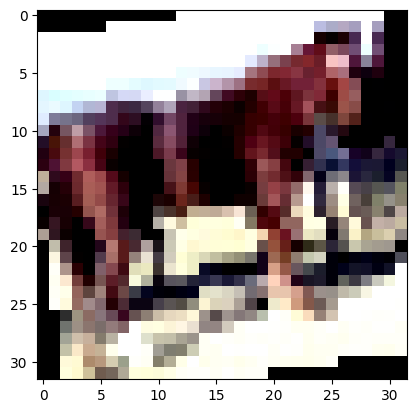

horse


In [12]:
imgs, labels = next(iter(train_loader))
img, label = imgs[0], labels[0].item()
print(img.shape, label)

imshow(img)
print(classes[label])

In [13]:
# Testing our model's class prediction on the image, with no training whatsoever

x = img.unsqueeze(0).to(device)
y_pred = model(x)
class_pred = y_pred.argmax(1, keepdim=True).item()
print(classes[class_pred])

car


## Training the Model

- Optimizer: Adam
- Loss Function: Cross Entropy Loss

In [14]:
LEARNING_RATE = 1e-3

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


criterion.to(device)

CrossEntropyLoss()

We will define some helper functions to aid in the training process. These are copied directly from Homework 2 Question 4.

In [15]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [16]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
EPOCHS = 30

train_loss_history = []
valid_loss_history = []
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
  start_time = time.time()
  train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
  end_time = time.time()
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

  train_loss_history.append(train_loss)
  valid_loss_history.append(valid_loss)

  train_time_min, train_time_sec = epoch_time(start_time, end_time)

  print(f"Epoch # {epoch}, Epoch Time: {train_time_min}:{train_time_sec}")
  print(f"Training Loss = {train_loss:.3f}, Training Accuracy = {train_acc:.3f}")
  print(f"Validation Loss = {valid_loss:.3f}, Validation Accuracy = {valid_acc:.3f}")
  print()

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), './state.pt')
    best_valid_loss = valid_loss

Epoch # 0, Epoch Time: 0:42
Training Loss = 1.676, Training Accuracy = 0.412
Validation Loss = 1.128, Validation Accuracy = 0.599

Epoch # 1, Epoch Time: 0:43
Training Loss = 1.113, Training Accuracy = 0.609
Validation Loss = 0.972, Validation Accuracy = 0.656

Epoch # 2, Epoch Time: 0:43
Training Loss = 0.899, Training Accuracy = 0.690
Validation Loss = 0.683, Validation Accuracy = 0.751

Epoch # 3, Epoch Time: 0:43
Training Loss = 0.768, Training Accuracy = 0.737
Validation Loss = 0.615, Validation Accuracy = 0.790

Epoch # 4, Epoch Time: 0:42
Training Loss = 0.670, Training Accuracy = 0.773
Validation Loss = 0.595, Validation Accuracy = 0.797

Epoch # 5, Epoch Time: 0:43
Training Loss = 0.604, Training Accuracy = 0.795
Validation Loss = 0.495, Validation Accuracy = 0.833

Epoch # 6, Epoch Time: 0:42
Training Loss = 0.551, Training Accuracy = 0.814
Validation Loss = 0.481, Validation Accuracy = 0.829

Epoch # 7, Epoch Time: 0:43
Training Loss = 0.508, Training Accuracy = 0.828
Valida

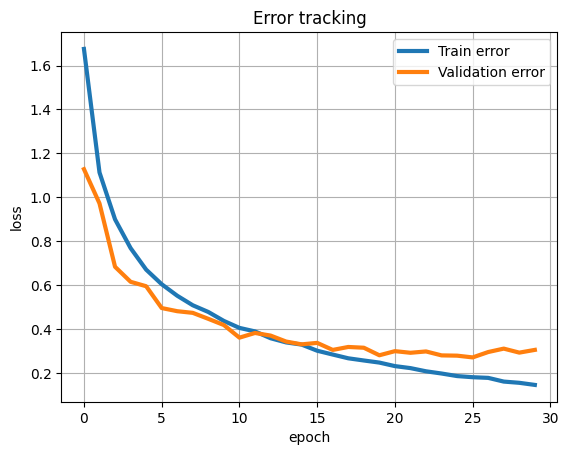

In [20]:
# Plot our training and validation loss over time

plt.plot(range(EPOCHS),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(EPOCHS),valid_loss_history,'-',linewidth=3,label='Validation error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Error tracking')
plt.grid(True)
plt.legend()
plt.show()

# Evaluating the model


We will load the parameters of our model that achieved the best validation loss and measure the test accuracy

In [21]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.908


In [22]:
print(LEARNING_RATE, BATCH_SIZE)

0.001 64


In [23]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
      
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            labels.append(y)
            probs.append(y_pred)


    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    return labels.cpu().numpy(), probs

In [24]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [25]:
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs.cpu(), 1).numpy()

print(pred_labels)

[3 8 8 ... 5 1 7]


In [26]:
classes = test_data.classes

In [27]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    plt.title('Confusion Matrix - CIFAR10 dataset')
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

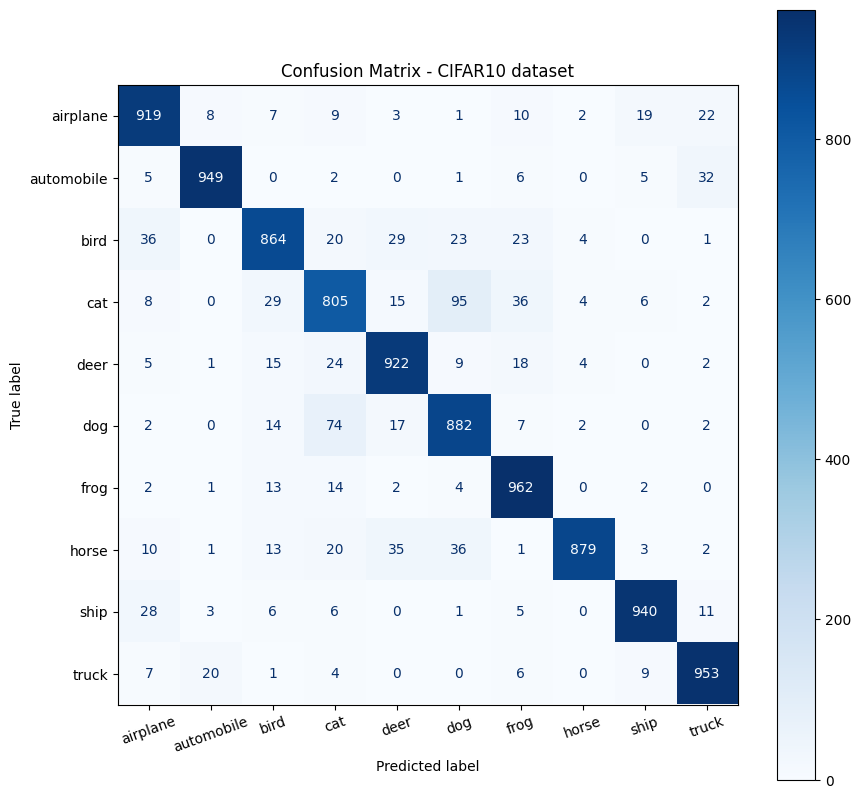

In [28]:
plot_confusion_matrix(labels, pred_labels, classes) 